# Detecting Anomalous Streams in the Pen Digit Dataset

In this notebook, we will use the [Pen Digit](https://archive.ics.uci.edu/dataset/81/pen+based+recognition+of+handwritten+digits) dataset to illustrate the use of the anomaly detection algorithms. See the [pen_digit_anomalies_data.ipynb](pen_digit_anomalies_data.ipynb) for the data download and preparation.

In [1]:
from __future__ import annotations
import random
import time
from typing import Callable

import numpy as np
import pandas as pd

import Data
from signature_mahalanobis_knn.utils import (
    compute_auc_given_dists,
    plot_cdf_given_dists,
)

from methods import (
    compute_signature_mahalanbois_knn_scores,
    compute_isolation_forest_scores_based_on_moments,
    compute_isolation_forest_scores_signatures,
    compute_local_outlier_factor_scores_based_on_moments,
    compute_local_outlier_factor_scores_signatures,
)

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)

bootstrap_samples = 10000

In [3]:
data = Data.Data(if_sample=False, random_seed=seed)
data.load_pen_digit()

depths = [1, 2, 3, 4, 5]
digits = range(10)

In [4]:
def pen_digit_experiment(
    data: Data.Data,
    depths: list[int],
    digits: list[int] | list[None],
    anomaly_detection_method: Callable[[Data.Data], dict[str, np.array | float]],
    anomaly_detection_kwargs: dict | None = None,
    add_depth_to_kwargs: bool = False,
    plot: bool = False,
    plot_kwargs: dict | None = None,
) -> dict[str, np.array | float]:
    t0 = time.time()

    if anomaly_detection_kwargs is None:
        anomaly_detection_kwargs = {}
    if plot_kwargs is None:
        plot_kwargs = {}

    results_pen_digit = {
        "depth": [],
        "auc": [],
        "se": [],
        "fit_times": [],
        "mean_fit_time": [],
        "total_fit_time": [],
        "compute_score_times": [],
        "mean_compute_score_time": [],
        "total_compute_score_time": [],
    }

    # loop through signatures depths
    for depth in depths:
        results_pen_digit["depth"].append(depth)
        digit_to_inlier_dists = {}
        digit_to_outlier_dists = {}
        fit_times = []
        compute_times = []

        # loop through the digits to compute inlier and outlier distances
        for digit in digits:
            data.load_pen_digit(digit=digit)
            print(f"start digit: {digit}, depth: {depth}")

            if add_depth_to_kwargs:
                anomaly_detection_kwargs["depth"] = depth

            # compute the inlier and outlier scores
            results = anomaly_detection_method(data, **anomaly_detection_kwargs)

            # save the inlier and outlier distances for digit
            digit_to_inlier_dists[digit] = results["scores_inliers"]
            digit_to_outlier_dists[digit] = results["scores_outliers"]

            # save fit and compute times
            fit_times.append(results["fit_time"])
            compute_times.append(results["compute_score_time"])

            # compute auc for digit
            auc = compute_auc_given_dists(
                results["scores_inliers"], results["scores_outliers"]
            )
            print(f"depth: {depth}, digit: {digit} | auc: {auc}")

        # plot and compute auc
        all_inlier_dists = np.concatenate(list(digit_to_inlier_dists.values()))
        all_outlier_dists = np.concatenate(list(digit_to_outlier_dists.values()))
        auc, se = compute_auc_given_dists(
            all_inlier_dists,
            all_outlier_dists,
            bootstrap=True,
            bootstrap_samples=bootstrap_samples,
            random_state=seed,
            plot=plot,
            title=f"Pen Digit (depth={depth})",
        )

        # save results
        results_pen_digit["auc"].append(auc)
        results_pen_digit["se"].append(se)
        results_pen_digit["fit_times"].append(fit_times)
        results_pen_digit["mean_fit_time"].append(np.mean(fit_times))
        results_pen_digit["total_fit_time"].append(np.sum(fit_times))
        results_pen_digit["compute_score_times"].append(compute_times)
        results_pen_digit["mean_compute_score_time"].append(np.mean(compute_times))
        results_pen_digit["total_compute_score_time"].append(np.sum(compute_times))

        if plot:
            # plot CDF
            plot_cdf_given_dists(
                all_inlier_dists,
                all_outlier_dists,
                bins=10000000,
                **plot_kwargs,
            )

        print(f"[Overall] depth: {depth} | auc: {auc}, se: {se}")

    total_time = time.time() - t0
    print(f"Total experiment time: {total_time} seconds | {total_time / 60} minutes")

    return results_pen_digit

## Signature Mahalanobis KNN

In [5]:
n_neighbours = 100

start digit: 0, depth: 1
fit_time: 4.044831991195679


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.1842901706695557
depth: 1, digit: 0 | auc: 0.9211659878471536
start digit: 1, depth: 1
fit_time: 0.24622797966003418


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.2478530406951904
depth: 1, digit: 1 | auc: 0.7991371662797956
start digit: 2, depth: 1
fit_time: 0.25603199005126953


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.1077587604522705
depth: 1, digit: 2 | auc: 0.9142040155122477
start digit: 3, depth: 1
fit_time: 0.23249387741088867


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.2112221717834473
depth: 1, digit: 3 | auc: 0.8743152502936659
start digit: 4, depth: 1
fit_time: 0.26061201095581055


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.1209280490875244
depth: 1, digit: 4 | auc: 0.9323364096018849
start digit: 5, depth: 1
fit_time: 0.22504806518554688


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0537610054016113
depth: 1, digit: 5 | auc: 0.8613445576417628
start digit: 6, depth: 1
fit_time: 0.28873419761657715


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0568978786468506
depth: 1, digit: 6 | auc: 0.8583895251649047
start digit: 7, depth: 1
fit_time: 0.22968792915344238


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.1509590148925781
depth: 1, digit: 7 | auc: 0.8134778431523806
start digit: 8, depth: 1
fit_time: 0.21238398551940918


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator
/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.0784080028533936
depth: 1, digit: 8 | auc: 0.917540604951658
start digit: 9, depth: 1
fit_time: 0.22435688972473145


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


compute_score_time: 1.208385705947876
depth: 1, digit: 9 | auc: 0.7821126434444745


/Users/rchan/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/rough_paths/signature_mahalanobis_knn/src/signature_mahalanobis_knn/sig_mahal_knn.py:267: RuntimeWarning: invalid value encountered in divide
  rho = numerator / denominator


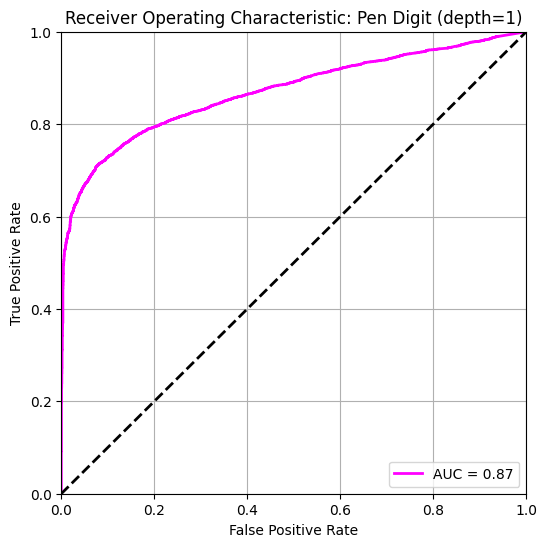

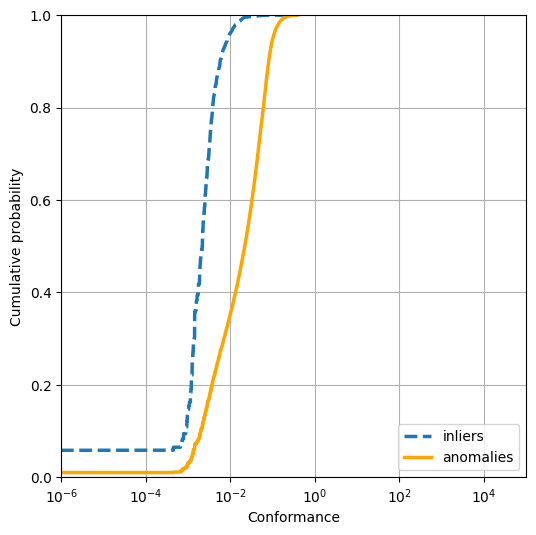

[Overall] depth: 1 | auc: 0.8696934836278613, se: 0.0022577909118422237
start digit: 0, depth: 2
fit_time: 0.22408676147460938
compute_score_time: 1.0840401649475098
depth: 2, digit: 0 | auc: 0.9914613731925606
start digit: 1, depth: 2
fit_time: 0.3753981590270996
compute_score_time: 1.0362977981567383
depth: 2, digit: 1 | auc: 0.8611664340764532
start digit: 2, depth: 2
fit_time: 0.28214502334594727
compute_score_time: 1.1633048057556152
depth: 2, digit: 2 | auc: 0.9266727210249863
start digit: 3, depth: 2
fit_time: 0.2886838912963867
compute_score_time: 1.236259937286377
depth: 2, digit: 3 | auc: 0.9704630508117225
start digit: 4, depth: 2
fit_time: 0.3486518859863281
compute_score_time: 1.2171759605407715
depth: 2, digit: 4 | auc: 0.9904144196581975
start digit: 5, depth: 2
fit_time: 0.31030821800231934
compute_score_time: 1.3334558010101318
depth: 2, digit: 5 | auc: 0.9076306736944427
start digit: 6, depth: 2
fit_time: 0.2509932518005371
compute_score_time: 1.1705090999603271
depth

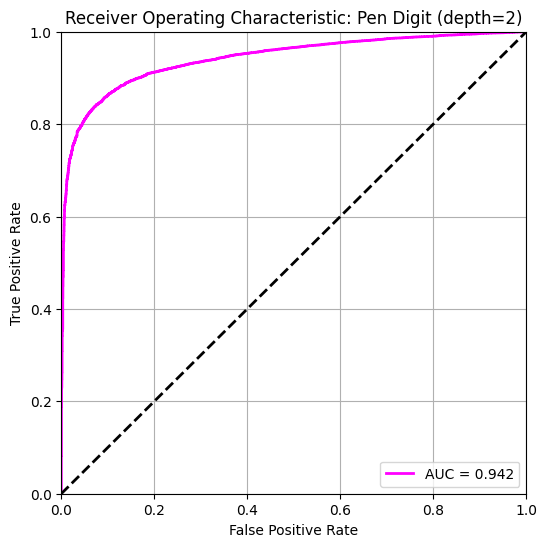

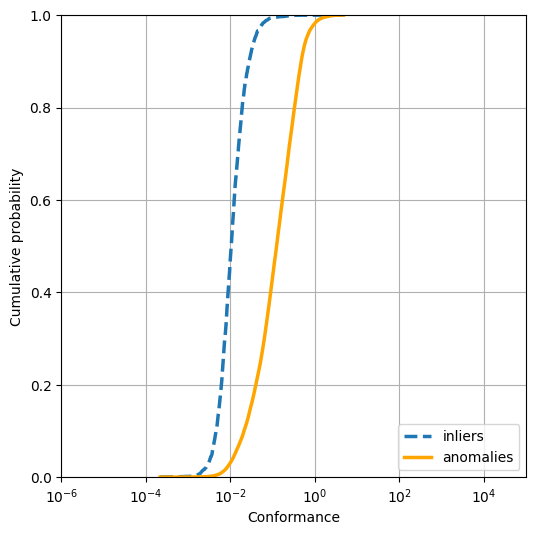

[Overall] depth: 2 | auc: 0.9420610228996693, se: 0.001534286527879381
start digit: 0, depth: 3
fit_time: 0.22539901733398438
compute_score_time: 1.1194698810577393
depth: 3, digit: 0 | auc: 0.9835940966867457
start digit: 1, depth: 3
fit_time: 0.2381281852722168
compute_score_time: 1.0866608619689941
depth: 3, digit: 1 | auc: 0.9162271997307097
start digit: 2, depth: 3
fit_time: 0.2897763252258301
compute_score_time: 1.151174783706665
depth: 3, digit: 2 | auc: 0.9466547332692833
start digit: 3, depth: 3
fit_time: 0.21373915672302246
compute_score_time: 1.1736140251159668
depth: 3, digit: 3 | auc: 0.9825805322128852
start digit: 4, depth: 3
fit_time: 0.261167049407959
compute_score_time: 1.1715431213378906
depth: 3, digit: 4 | auc: 0.994815809589262
start digit: 5, depth: 3
fit_time: 0.260998010635376
compute_score_time: 1.1419639587402344
depth: 3, digit: 5 | auc: 0.8856177537856088
start digit: 6, depth: 3
fit_time: 0.31142115592956543
compute_score_time: 1.206186056137085
depth: 3, 

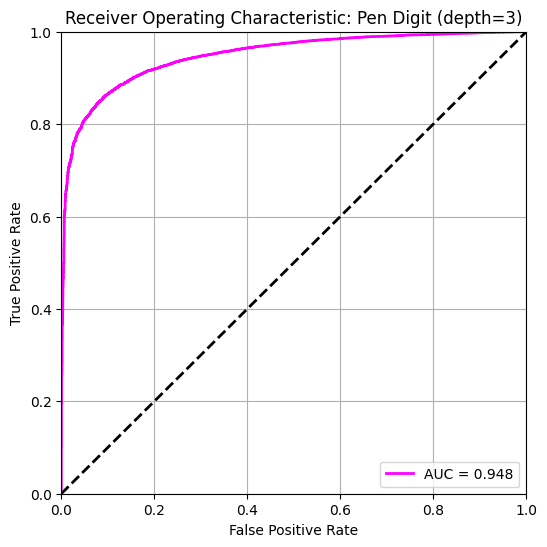

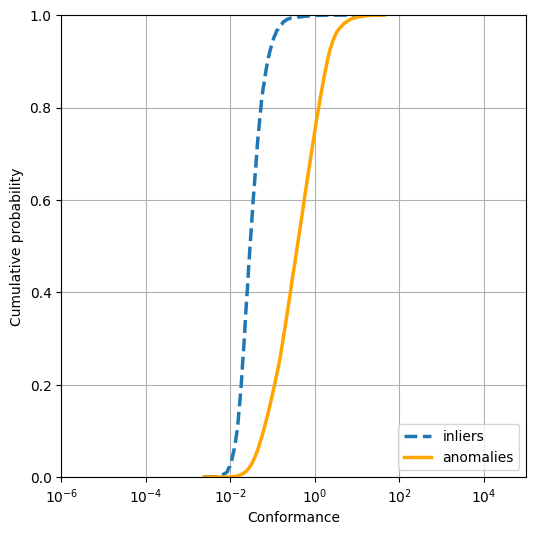

[Overall] depth: 3 | auc: 0.9483626263025813, se: 0.0015001563858763392
start digit: 0, depth: 4
fit_time: 0.23873019218444824
compute_score_time: 1.5563900470733643
depth: 4, digit: 0 | auc: 0.9836556078400358
start digit: 1, depth: 4
fit_time: 0.22207999229431152
compute_score_time: 1.3713111877441406
depth: 4, digit: 1 | auc: 0.9396051459708128
start digit: 2, depth: 4
fit_time: 0.22790217399597168
compute_score_time: 1.3123347759246826
depth: 4, digit: 2 | auc: 0.9497123011003037
start digit: 3, depth: 4
fit_time: 0.2621269226074219
compute_score_time: 1.315377950668335
depth: 4, digit: 3 | auc: 0.986003810126201
start digit: 4, depth: 4
fit_time: 0.22788095474243164
compute_score_time: 1.4088609218597412
depth: 4, digit: 4 | auc: 0.9953715716319418
start digit: 5, depth: 4
fit_time: 0.23716187477111816
compute_score_time: 1.3941872119903564
depth: 4, digit: 5 | auc: 0.9014047687581693
start digit: 6, depth: 4
fit_time: 0.2587778568267822
compute_score_time: 1.414308786392212
depth

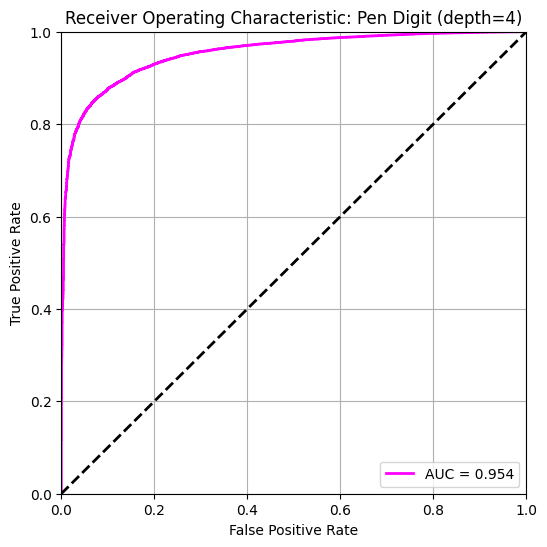

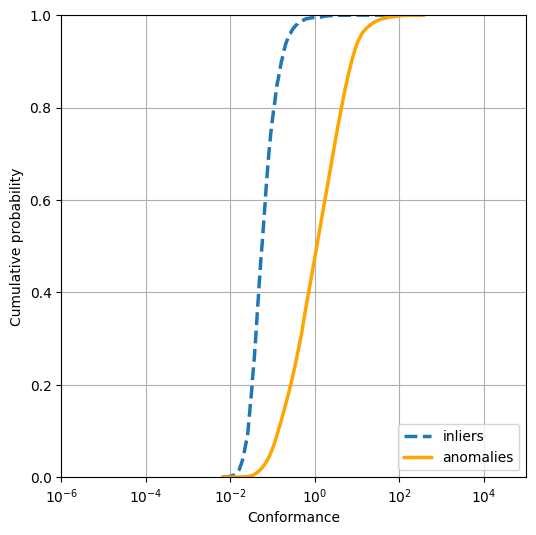

[Overall] depth: 4 | auc: 0.9537724262122033, se: 0.0014253017221274328
start digit: 0, depth: 5
fit_time: 0.2440199851989746
compute_score_time: 1.805534839630127
depth: 5, digit: 0 | auc: 0.9820158962394716
start digit: 1, depth: 5
fit_time: 0.26087307929992676
compute_score_time: 1.758540153503418
depth: 5, digit: 1 | auc: 0.9505196462758685
start digit: 2, depth: 5
fit_time: 0.2590029239654541
compute_score_time: 1.6346871852874756
depth: 5, digit: 2 | auc: 0.9542346613182605
start digit: 3, depth: 5
fit_time: 0.26955604553222656
compute_score_time: 1.5703339576721191
depth: 5, digit: 3 | auc: 0.9871464714918226
start digit: 4, depth: 5
fit_time: 0.29588913917541504
compute_score_time: 1.7670540809631348
depth: 5, digit: 4 | auc: 0.9957721761327377
start digit: 5, depth: 5
fit_time: 0.2990570068359375
compute_score_time: 1.5861339569091797
depth: 5, digit: 5 | auc: 0.9005223644660039
start digit: 6, depth: 5
fit_time: 0.3434009552001953
compute_score_time: 1.834364891052246
depth: 

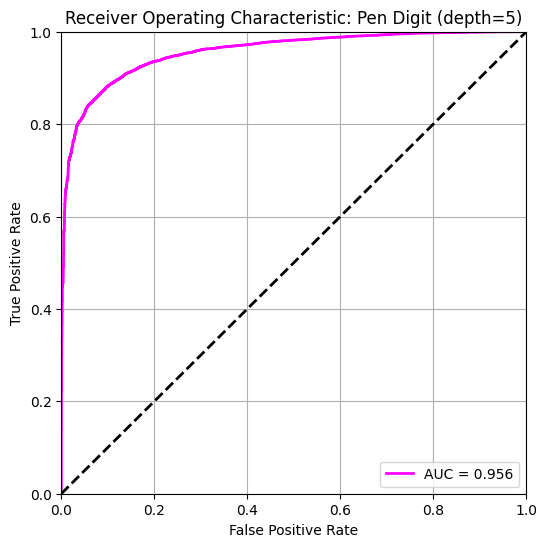

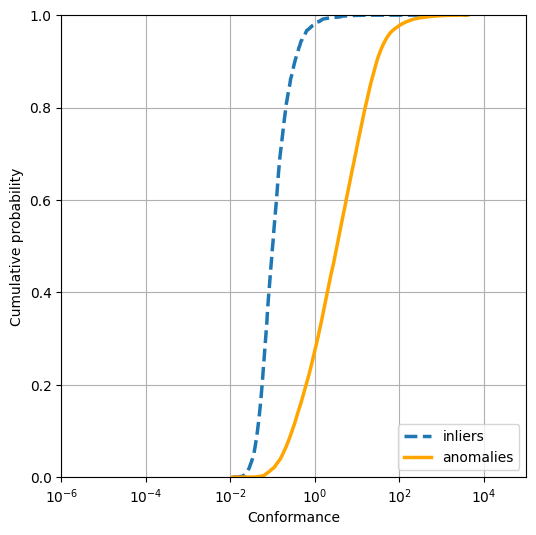

[Overall] depth: 5 | auc: 0.9561069665118339, se: 0.0013886514247386079
Total experiment time: 579.4038100242615 seconds | 9.656730167071025 minutes


In [7]:
results_pen_digit_signature_mahalanobis_knn = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_signature_mahalanbois_knn_scores,
    anomaly_detection_kwargs={
        "knn_library": "sklearn",
        "n_neighbours": n_neighbours,
        "random_state": seed,
    },
    add_depth_to_kwargs=True,
    plot=True,
    plot_kwargs={"xrange": (10e-7, 10e4), "xlog": True},
)

In [8]:
pd.DataFrame(results_pen_digit_signature_mahalanobis_knn)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.869693,0.002258,"[4.044831991195679, 0.24622797966003418, 0.256...",0.622041,6.220409,"[1.1842901706695557, 1.2478530406951904, 1.107...",1.142046,11.420464
1,2,0.942061,0.001534,"[0.22408676147460938, 0.3753981590270996, 0.28...",0.282311,2.823114,"[1.0840401649475098, 1.0362977981567383, 1.163...",1.152784,11.527845
2,3,0.948363,0.001500,"[0.22539901733398438, 0.2381281852722168, 0.28...",0.261382,2.613816,"[1.1194698810577393, 1.0866608619689941, 1.151...",1.173524,11.735244
3,4,0.953772,0.001425,"[0.23873019218444824, 0.22207999229431152, 0.2...",0.235921,2.359206,"[1.5563900470733643, 1.3713111877441406, 1.312...",1.381488,13.814879
4,5,0.956107,0.001389,"[0.2440199851989746, 0.26087307929992676, 0.25...",0.285085,2.850845,"[1.805534839630127, 1.758540153503418, 1.63468...",1.728865,17.288646


In [9]:
pd.DataFrame(results_pen_digit_signature_mahalanobis_knn).to_csv(
    "results/pen_digit_signature_mahalanobis_knn.csv"
)

## Baseline: Isolation Forest

### Using moments as features

In [10]:
results_pen_digit_isolation_forest_moments = pen_digit_experiment(
    data=data,
    depths=[None],
    digits=digits,
    anomaly_detection_method=compute_isolation_forest_scores_based_on_moments,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

start digit: 0, depth: None
fit_time: 0.046945810317993164
compute_score_time: 0.013569831848144531
depth: None, digit: 0 | auc: 0.6953168044077135
start digit: 1, depth: None
fit_time: 0.04585099220275879
compute_score_time: 0.013193130493164062
depth: None, digit: 1 | auc: 0.5978807408290496
start digit: 2, depth: None
fit_time: 0.04725217819213867
compute_score_time: 0.01317596435546875
depth: None, digit: 2 | auc: 0.6243320336332461
start digit: 3, depth: None
fit_time: 0.04807400703430176
compute_score_time: 0.01420903205871582
depth: None, digit: 3 | auc: 0.6589965287190145
start digit: 4, depth: None
fit_time: 0.046514034271240234
compute_score_time: 0.013813972473144531
depth: None, digit: 4 | auc: 0.6143432190018023
start digit: 5, depth: None
fit_time: 0.0479731559753418
compute_score_time: 0.01371002197265625
depth: None, digit: 5 | auc: 0.6008135106950232
start digit: 6, depth: None
fit_time: 0.04632687568664551
compute_score_time: 0.014419078826904297
depth: None, digit: 6

In [11]:
pd.DataFrame(results_pen_digit_isolation_forest_moments)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,None,0.617815,0.005033,"[0.046945810317993164, 0.04585099220275879, 0....",0.046756,0.467565,"[0.013569831848144531, 0.013193130493164062, 0...",0.013675,0.136751


In [12]:
pd.DataFrame(results_pen_digit_isolation_forest_moments).to_csv(
    "results/pen_digit_isolation_forest_moments.csv"
)

### Using path signatures as features

In [13]:
results_pen_digit_isolation_forest_signatures = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_isolation_forest_scores_signatures,
    anomaly_detection_kwargs={"random_state": seed},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

start digit: 0, depth: 1
fit_time: 0.05082893371582031
compute_score_time: 0.014255046844482422
depth: 1, digit: 0 | auc: 0.9530520516166449
start digit: 1, depth: 1
fit_time: 0.047516822814941406
compute_score_time: 0.015080928802490234
depth: 1, digit: 1 | auc: 0.8214702097519584
start digit: 2, depth: 1
fit_time: 0.04784202575683594
compute_score_time: 0.011804819107055664
depth: 1, digit: 2 | auc: 0.922368633281205
start digit: 3, depth: 1
fit_time: 0.04734635353088379
compute_score_time: 0.014419794082641602
depth: 1, digit: 3 | auc: 0.9004571586699197
start digit: 4, depth: 1
fit_time: 0.0490260124206543
compute_score_time: 0.011832952499389648
depth: 1, digit: 4 | auc: 0.9524240516981423
start digit: 5, depth: 1
fit_time: 0.07492709159851074
compute_score_time: 0.020180940628051758
depth: 1, digit: 5 | auc: 0.7808721174399895
start digit: 6, depth: 1
fit_time: 0.046830177307128906
compute_score_time: 0.011755943298339844
depth: 1, digit: 6 | auc: 0.8916128279268697
start digit: 

In [14]:
pd.DataFrame(results_pen_digit_isolation_forest_signatures)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.887891,0.002464,"[0.05082893371582031, 0.047516822814941406, 0....",0.050848,0.508476,"[0.014255046844482422, 0.015080928802490234, 0...",0.014093,0.140931
1,2,0.930849,0.002339,"[0.04678916931152344, 0.04589271545410156, 0.0...",0.046351,0.463508,"[0.010293006896972656, 0.015023946762084961, 0...",0.012366,0.123659
2,3,0.916448,0.002924,"[0.044999122619628906, 0.046234846115112305, 0...",0.047301,0.473015,"[0.010683059692382812, 0.014012336730957031, 0...",0.011738,0.117376
3,4,0.875179,0.003543,"[0.04493522644042969, 0.044239044189453125, 0....",0.044819,0.448190,"[0.009649276733398438, 0.012599945068359375, 0...",0.010943,0.109433
4,5,0.834366,0.004039,"[0.043366193771362305, 0.04369711875915527, 0....",0.043972,0.439725,"[0.009205102920532227, 0.01191091537475586, 0....",0.010267,0.102670


In [15]:
pd.DataFrame(results_pen_digit_isolation_forest_signatures).to_csv(
    "results/pen_digit_isolation_forest_signatures.csv"
)

## Baseline: Local Outlier Factor


### Using moments as features

In [16]:
results_pen_digit_local_outlier_factor_moments = pen_digit_experiment(
    data=data,
    depths=[None],
    digits=digits,
    anomaly_detection_method=compute_local_outlier_factor_scores_based_on_moments,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=False,
    plot=False,
    plot_kwargs=None,
)

start digit: 0, depth: None
fit_time: 0.05527901649475098
compute_score_time: 1.3828277587890625e-05
depth: None, digit: 0 | auc: 0.5645766055509422
start digit: 1, depth: None
fit_time: 0.05617809295654297
compute_score_time: 1.3828277587890625e-05
depth: None, digit: 1 | auc: 0.48129957151973746
start digit: 2, depth: None
fit_time: 0.059298038482666016
compute_score_time: 1.5020370483398438e-05
depth: None, digit: 2 | auc: 0.5001209702868924
start digit: 3, depth: None
fit_time: 0.05698800086975098
compute_score_time: 1.5020370483398438e-05
depth: None, digit: 3 | auc: 0.5779052212282763
start digit: 4, depth: None
fit_time: 0.054939985275268555
compute_score_time: 1.71661376953125e-05
depth: None, digit: 4 | auc: 0.4744095247445599
start digit: 5, depth: None
fit_time: 0.058573007583618164
compute_score_time: 1.52587890625e-05
depth: None, digit: 5 | auc: 0.500634670466825
start digit: 6, depth: None
fit_time: 0.05592966079711914
compute_score_time: 1.0013580322265625e-05
depth: No

In [17]:
pd.DataFrame(results_pen_digit_local_outlier_factor_moments)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,None,0.513893,0.005179,"[0.05527901649475098, 0.05617809295654297, 0.0...",0.056816,0.568165,"[1.3828277587890625e-05, 1.3828277587890625e-0...",0.000015,0.000151


In [18]:
pd.DataFrame(results_pen_digit_local_outlier_factor_moments).to_csv(
    "results/pen_digit_local_outlier_factor_moments.csv"
)

### Using path signatures as features

In [19]:
results_pen_digit_local_outlier_factor_signatures = pen_digit_experiment(
    data=data,
    depths=depths,
    digits=digits,
    anomaly_detection_method=compute_local_outlier_factor_scores_signatures,
    anomaly_detection_kwargs={"n_neighbors": n_neighbours},
    add_depth_to_kwargs=True,
    plot=False,
    plot_kwargs=None,
)

start digit: 0, depth: 1
fit_time: 0.04373502731323242
compute_score_time: 1.5020370483398438e-05
depth: 1, digit: 0 | auc: 0.5630783696029455
start digit: 1, depth: 1
fit_time: 0.04327106475830078
compute_score_time: 1.0967254638671875e-05
depth: 1, digit: 1 | auc: 0.6167087140683184
start digit: 2, depth: 1
fit_time: 0.04273581504821777
compute_score_time: 1.3113021850585938e-05
depth: 1, digit: 2 | auc: 0.5965636549156014
start digit: 3, depth: 1
fit_time: 0.04315900802612305
compute_score_time: 2.5033950805664062e-05
depth: 1, digit: 3 | auc: 0.7332746942863166
start digit: 4, depth: 1
fit_time: 0.043582916259765625
compute_score_time: 1.5020370483398438e-05
depth: 1, digit: 4 | auc: 0.5749082203692925
start digit: 5, depth: 1
fit_time: 0.042752981185913086
compute_score_time: 2.002716064453125e-05
depth: 1, digit: 5 | auc: 0.4665705616715663
start digit: 6, depth: 1
fit_time: 0.043675899505615234
compute_score_time: 1.8835067749023438e-05
depth: 1, digit: 6 | auc: 0.58835671365320

In [20]:
pd.DataFrame(results_pen_digit_local_outlier_factor_signatures)

,depth,auc,se,fit_times,mean_fit_time,total_fit_time,compute_score_times,mean_compute_score_time,total_compute_score_time
0,1,0.562677,0.004958,"[0.04373502731323242, 0.04327106475830078, 0.0...",0.043073,0.430730,"[1.5020370483398438e-05, 1.0967254638671875e-0...",0.000018,0.000182
1,2,0.583752,0.005116,"[0.0677940845489502, 0.06586122512817383, 0.06...",0.065287,0.652868,"[1.3828277587890625e-05, 1.7881393432617188e-0...",0.000018,0.000178
2,3,0.582125,0.005142,"[0.08650612831115723, 0.08527588844299316, 0.0...",0.083243,0.832434,"[2.4080276489257812e-05, 1.9073486328125e-05, ...",0.000019,0.000186
3,4,0.581709,0.005143,"[0.07949113845825195, 0.07964491844177246, 0.0...",0.080258,0.802583,"[2.09808349609375e-05, 2.002716064453125e-05, ...",0.000021,0.000208
4,5,0.581650,0.005144,"[0.09238195419311523, 0.23294830322265625, 0.0...",0.111471,1.114711,"[1.6927719116210938e-05, 1.7881393432617188e-0...",0.000020,0.000196


In [21]:
pd.DataFrame(results_pen_digit_local_outlier_factor_signatures).to_csv(
    "results/pen_digit_local_outlier_factor_signatures.csv"
)